In [4]:
import pandas as pd
from PIL import Image
import io
import json
import matplotlib.pyplot as plt
import re

In [5]:
parquet_file = [
    'data/train-00000-of-00004-b4aaeceff1d90ecb.parquet',
    'data/train-00001-of-00004-7dbbe248962764c5.parquet',
    'data/train-00002-of-00004-688fe1305a55e5cc.parquet',
    'data/train-00003-of-00004-2d0cd200555ed7fd.parquet'
    ]

df = pd.concat([pd.read_parquet(f) for f in parquet_file])

In [6]:
len(df)

800

In [7]:
df.head()

,image,ground_truth
0,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,"{""gt_parse"": {""menu"": [{""nm"": ""Nasi Campur Bal..."
1,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,"{""gt_parse"": {""menu"": [{""nm"": ""SPGTHY BOLOGNAS..."
2,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,"{""gt_parse"": {""menu"": [{""nm"": ""HAKAU UDANG"", ""..."
3,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,"{""gt_parse"": {""menu"": [{""nm"": ""Bintang Bremer""..."
4,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,"{""gt_parse"": {""menu"": {""nm"": ""BASO BIHUN"", ""un..."


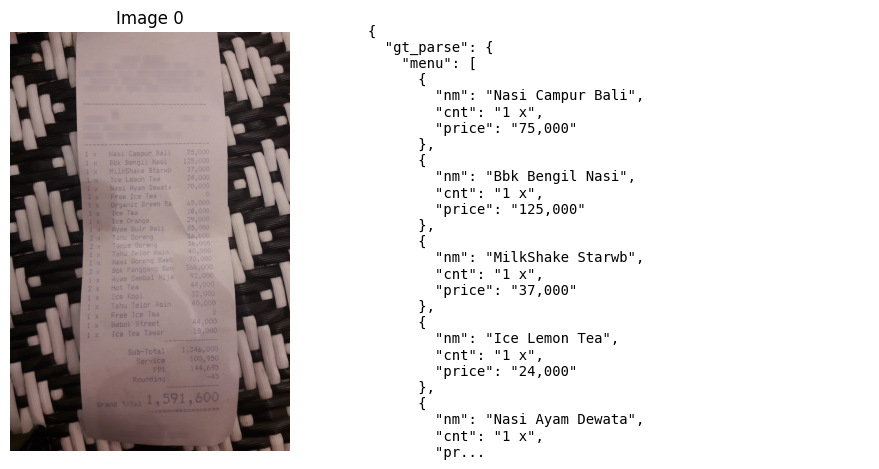

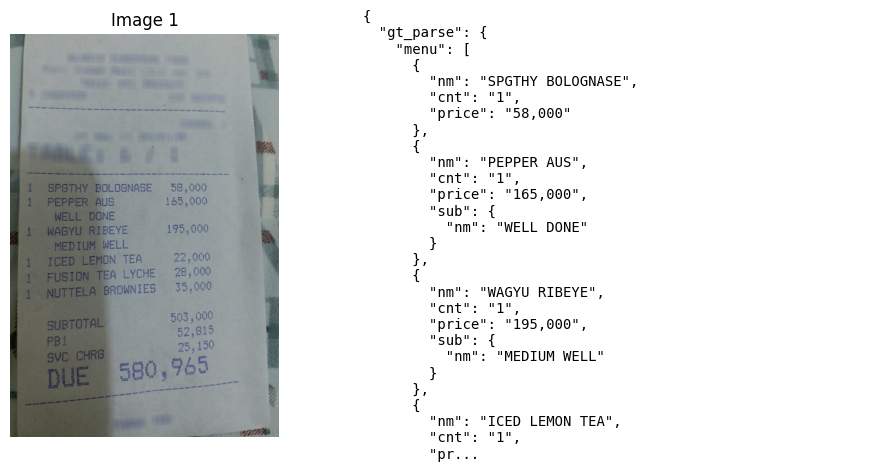

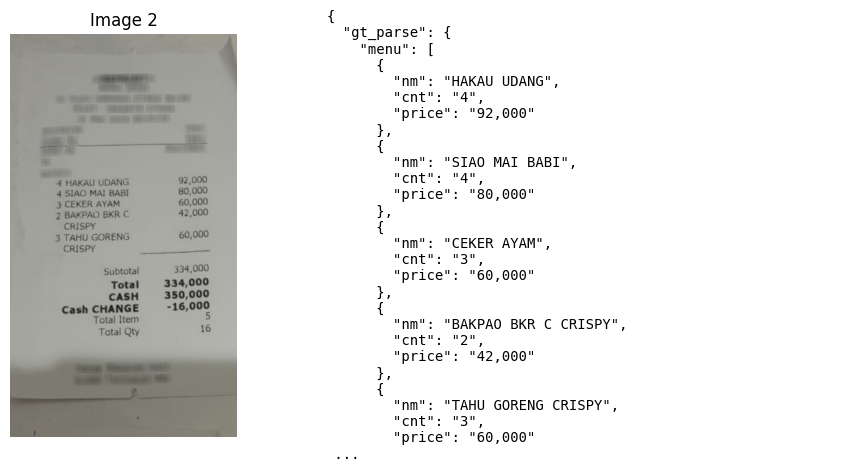

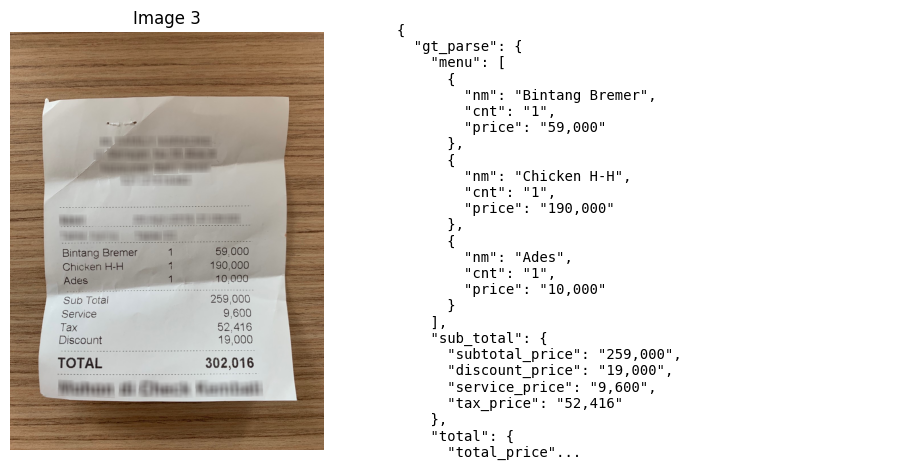

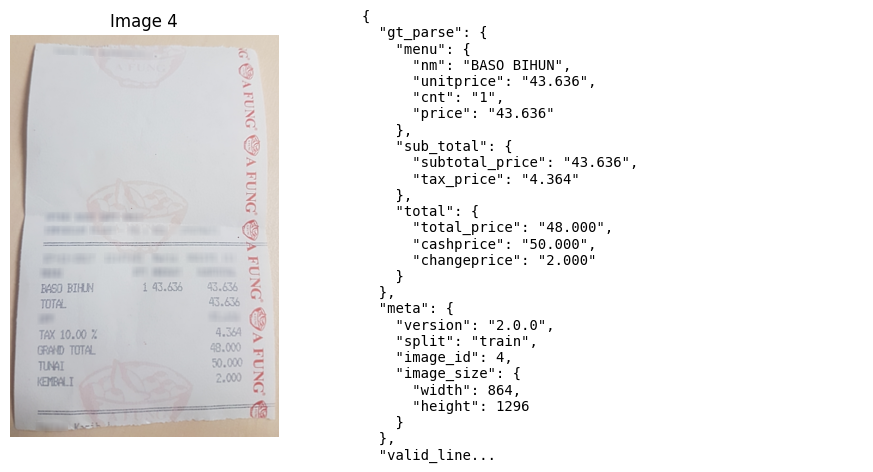

Full ground truth for image 4:
{
  "gt_parse": {
    "menu": {
      "nm": "BASO BIHUN",
      "unitprice": "43.636",
      "cnt": "1",
      "price": "43.636"
    },
    "sub_total": {
      "subtotal_price": "43.636",
      "tax_price": "4.364"
    },
    "total": {
      "total_price": "48.000",
      "cashprice": "50.000",
      "changeprice": "2.000"
    }
  },
  "meta": {
    "version": "2.0.0",
    "split": "train",
    "image_id": 4,
    "image_size": {
      "width": 864,
      "height": 1296
    }
  },
  "valid_line": [
    {
      "words": [
        {
          "quad": {
            "x2": 172,
            "y3": 836,
            "x3": 172,
            "y4": 836,
            "x1": 96,
            "y1": 800,
            "x4": 96,
            "y2": 800
          },
          "is_key": 0,
          "row_id": 2119099,
          "text": "BASO"
        },
        {
          "quad": {
            "x2": 272,
            "y3": 834,
            "x3": 272,
            "y4": 834,
       

In [8]:
for index, row in df.head(5).iterrows():
    image_data = row['image']
    image = Image.open(io.BytesIO(image_data['bytes']))
    
    # Create a subplot with 1 row and 2 columns
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    
    # Display the image on the left side
    ax[0].imshow(image)
    ax[0].set_title(f"Image {index}")
    ax[0].axis('off')
    
    # Parse the ground truth JSON string to a Python object
    ground_truth = json.loads(row['ground_truth'])  # Parse JSON string to a Python dict
    formatted_gt = json.dumps(ground_truth, indent=2)  # Convert dict to pretty JSON string
    
    # Display the JSON-formatted ground truth on the right side
    truncated_gt = (formatted_gt[:500] + '...') if len(formatted_gt) > 500 else formatted_gt
    ax[1].text(0, 0.5, truncated_gt, wrap=True, fontsize=10, verticalalignment='center', 
               family='monospace', transform=ax[1].transAxes)  # Use monospace font for JSON
    ax[1].axis('off')
    
    plt.tight_layout()
    plt.show()

    if index == 4:  # Change this to any other index if needed
        print(f"Full ground truth for image {index}:\n{formatted_gt}\n")